Project content:


1.   Train first model on digits dataset
2.   Train second model on alphabet dataset

I will be using the same model structure for both models and note the differences if any.

For the first model, I will be using a project by Yassine Ghouzam as a reference.

For the second model, I will be using the data set provided by Yair Hadad.

Reference project 1: https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6

Reference project 2: https://www.kaggle.com/yairhadad1/cnn-for-handwritten-alphabets





In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


Train and test datasets for the first model are read from files store on my google drive.  The drive is mounted on this notebook for easy access.

In [0]:
train = pd.read_csv("drive/My Drive/Colab Notebooks/602Project/train.csv")
test = pd.read_csv("drive/My Drive/Colab Notebooks/602Project/test.csv")

In [3]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [4]:
train.shape

(42000, 785)

X_train and Y_train variables are initialized.

Y_train is the set of target labels that is derived from the 'label' feature of the train dataset

X_train is derived from the remaining features of the train dataset.

Each feature is a pixel value.  There are a total of 784 pixels per image. (28 X 28)

In [0]:
Y_train = train["label"]
X_train = train.drop(labels = ["label"],axis = 1) 

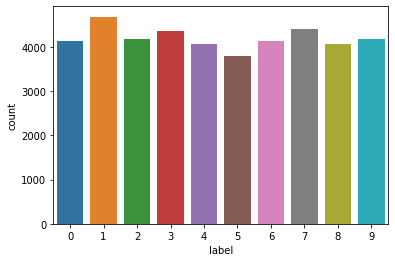

In [6]:
sns.countplot(Y_train)

Check the data for null or missing values values

In [7]:
# Check the data
X_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [8]:
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

Pixel values are normally between 0 and 255 (for greyscale images).  We scale it to values between 0 and 1 to help achieve faster convergance of our model

In [0]:
# Normalize the data
X_train = X_train / 255.0
test = test / 255.0

Convert each record of data into a 28 X 28 matrix. (28 X 28 X 1) since it is greyscale and there are no additional RGB colour layers.  If it were to be coloured, we would have a matrix of 28 X 28 X 3. 

CNN works on inputs that are in matrix format.

In [0]:
# Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1)
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

Convert the vector into a binary class matrix with values from 1 to 10 (for the 10 digits that are labels)

In [0]:
Y_train = to_categorical(Y_train, num_classes = 10)

Create a train-test split on the X_train dataset (and the Y_train dataset)

In [0]:
random_seed = 2
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=random_seed)

Plot the image at index 0.  As you can see, the image at the first index is 5.  Y_train[0] stores a list of probabilities of what the image could be.  The 6th index corresponds to the value '5'.

X_train[0][ :, :, 0] takes the first index of X_train, the entire range of pixels from the first 2 dimensions and the first and only colour channel (0)

[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


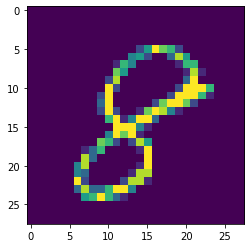

In [14]:
g = plt.imshow(X_train[0][:,:,0])
print(Y_train[0])

Now we define our model.

I have chosen to work with a CNN model as I feel it is best suited towards image processing.

It is a sequential model.

The layers are defined as follows:


*   2D convolutional layer.  The filter uses "same" padding.  This means that the dimension of the data is maintained and no data is lost while propogating through this layer.  I have chosen "relu" (rectified linear unit) as it's activation function.  This layer has a set of 32 filter associated with it.  The kernal size I have selected is 5 X 5.  

There are two convolutional layers back to back
*    MaxPool layer.  This layer acts a a downsampling filter.It takes the maximum values from different regions of the input and returns an output with those values.  The output intentionally has a lower number of dimensions as compared to the input.  this is a measure to reduce overfitting.


*   Dropout layer.  This layer is used for regularization.  This layer randomly ignores certain nodes. in each training sample.  this forces the network to learn features in a distributed way.  this layer is quite useful when it comes to processing handwritten integers because everyone has a different style of writing.

*   The above structure is repeated again with smaller kernels.


*   Flatten layer.  This layer converts the final feature map into a 1-D vector.  The output of this layer can then be passed to a fully connected layer to make predictions.


*   Dense layer.  The last two dense layers behave like a simple artificial neral network (ANN).  the first one uses a 'relu' activation function and the second one uses a 'softmax' activation function.  The softmax function is used because we have 10 different probability values that we need to predict.  If it was just two, I cold have also used a sigmoid function.


In [0]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

In [16]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        832       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        25632     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)         

Compile the model using an 'adam' optimizer.  The loss function selected is 'categorical cross entropy'.  

In [0]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

Data Augmentation:

In this step, we modify our input data so that our model's performance is boosted.  Modifying data could be doe by expanding the image, inverting the image, darkening the image adding brightness to the image etc.

This is usually done when our training data set is limited.

In the real world, our eye is able to tell what number we are looking at regardless of whether it is inverted or not.  Data augmentation helps our model come a little closer to doing that.

In [0]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)


In [0]:
epochs = 1
batch_size = 86

The learning rate reduction algorithm decreases the LR every epoch.  In case it is on a plateu, the ReduceOnPlateau method reduces the LR by half (factor) if accuracy isn't imporved within 3 epochs (patience)

In [0]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

Now we train the model.

In [21]:
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

Epoch 1/1
 - 260s - loss: 0.4161 - accuracy: 0.8648 - val_loss: 0.0672 - val_accuracy: 0.9807


Now I prepare the handwritten alphabet dataset.  The labels are integers (0 -> 25).  I need to convert them into alphabets.

The dataset was obtained from the notebook belonging to Yair Hadad.

In [0]:
df = pd.read_csv("drive/My Drive/Colab Notebooks/602Project/A_Z Handwritten Data.csv").astype('float32')

In [0]:
df.rename(columns={'0':'label'}, inplace=True)

In [41]:
df.head()

,label,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.10,0.11,0.12,0.13,0.14,0.15,0.16,0.17,0.18,0.19,0.20,0.21,0.22,0.23,0.24,0.25,0.26,0.27,0.28,0.29,0.30,0.31,0.32,0.33,0.34,0.35,0.36,0.37,0.38,0.39,...,0.609,0.610,0.611,0.612,0.613,0.614,0.615,0.616,0.617,0.618,0.619,0.620,0.621,0.622,0.623,0.624,0.625,0.626,0.627,0.628,0.629,0.630,0.631,0.632,0.633,0.634,0.635,0.636,0.637,0.638,0.639,0.640,0.641,0.642,0.643,0.644,0.645,0.646,0.647,0.648
0,A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
X = df.drop('label',axis = 1)
y = df['label']

The original labels are integers from 0 -> 25.  To make it easier for the end user to read and understand, I am mapping them to the alphabets that they correspond to.

In [0]:
alphabets_mapper = {0:'A',1:'B',2:'C',3:'D',4:'E',5:'F',6:'G',7:'H',8:'I',
                    9:'J',10:'K',11:'L',12:'M',13:'N',14:'O',15:'P',16:'Q',
                    17:'R',18:'S',19:'T',20:'U',21:'V',22:'W',23:'X',24:'Y',25:'Z'}

df["label"] = df["label"].map(alphabets_mapper) 

I am using the same model as the hand-drawn integer dataset.  I want to compare the differences in using the same model on two datasets.  the only difference between them is that the last dense layer has an output of a vector of length 26 with probablilities of what alphabet it might be.

In [0]:
model2 = Sequential()

model2.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model2.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model2.add(MaxPool2D(pool_size=(2,2)))
model2.add(Dropout(0.25))


model2.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model2.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model2.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model2.add(Dropout(0.25))


model2.add(Flatten())
model2.add(Dense(256, activation = "relu"))
model2.add(Dropout(0.5))
model2.add(Dense(26, activation = "softmax"))

Splitting of dataset into train and test sub sets.

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X,y)

MinMAxScaler to scale pixel values to the range (0,1).  this is done to help achieve convergence faster.

Both test and train feature dataset is transformed.

In [0]:
from sklearn.preprocessing import MinMaxScaler

standard_scaler = MinMaxScaler()
standard_scaler.fit(X_train)

X_train = standard_scaler.transform(X_train)
X_test = standard_scaler.transform(X_test)

Reshape the datasets into a 28 28 X 1 matrix (since it is greyscale)

In [0]:
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32')

In [0]:
from keras.utils import np_utils

Convert label to a binary class matrix

In [0]:
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

The same optimizer and loss function as the first model

In [0]:
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [33]:
history = model2.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=2, batch_size=200, verbose=2)

Train on 279337 samples, validate on 93113 samples
Epoch 1/2
 - 1915s - loss: 0.2431 - accuracy: 0.9314 - val_loss: 0.0614 - val_accuracy: 0.9838
Epoch 2/2
 - 1917s - loss: 0.0850 - accuracy: 0.9770 - val_loss: 0.0439 - val_accuracy: 0.9881


In [0]:
preds = model2.predict(X_test[:5])

Predict the values of the X_test feature dataset.

preds is a list of output vectors from model2.  As stated before. the vectors contain probabilities of what the input could be.  The example above contains the alphabet 'p'.  The 16th index has a value of almost 1.

array([4.1163123e-08, 5.4210169e-08, 1.2277167e-06, 6.1133443e-10,
       4.2160263e-08, 4.2440771e-09, 5.7452918e-09, 7.1728712e-10,
       1.6524700e-14, 9.6117580e-13, 1.1431513e-10, 5.1582427e-10,
       3.5075062e-10, 7.0992807e-09, 7.9410611e-08, 9.9999130e-01,
       7.3555519e-08, 7.1130758e-06, 3.4752457e-08, 7.3943540e-10,
       4.6180833e-13, 5.4941471e-14, 3.3614225e-13, 1.6297089e-13,
       8.1795137e-10, 1.8888429e-11], dtype=float32)

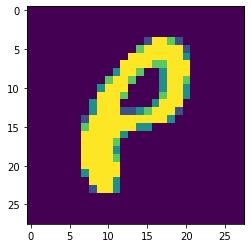

In [46]:
plt.imshow(X_test[0].reshape(28,28))
preds[0]

Conclusion:

The same model structure was used on two different datasets.  Both managed to achieve 98% accurracy.  The only modification to the model structure that was required was changing the length of the output vector to 26 to correspond to the 26 letters of the english language.

Coming from a hardcore software engineering background, I was used to building architectures specifically catered to the input data that the system would recieve.  It was interesting to find that the same structure could be used to train a model with two completely different input datasets, with minimal modifications. 